# ADA (Advanced Data Analytics) - Assignment 2

    Aidan Kealey | 20151256

## Imports

In [12]:
import os
import argparse
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import functional
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

## Configure System

In [13]:
print(f"PyTorch version: {torch.__version__}")
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")
# device = "mps" if torch.backends.mps.is_available() else "cpu"
if torch.cuda.is_available():
    print('using cuda ...')
    device = "cuda" if torch.cuda.is_available() else "cpu"
elif torch.backends.mps.is_available():
    print('using mps ...')
    device = "mps" if torch.backends.mps.is_available() else "cpu"
else:
    print('using cpu ...')
    device = torch.device("cpu")
# device = torch.device("cpu")
# device = torch.device("mps")
print(f"Using device: {device}")

PyTorch version: 2.1.1
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
using mps ...
Using device: mps


In [14]:
# device = torch.device("cpu")
# device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


## The Model

### Model Motivation:

The model took heavy inspiration from the Food Image Classification Tutorial model. This was due to ease of implementation and allowed me to understand the tutorial better. The model consists of 2 sections (cnn and fc). Within the cnn, the structure is fairly consistent with the structure seen in the tutorial, however, the last layer which was originally taking in [512, 8, 8] and outputting [512, 4, 4] was changed to two layers where layer 1 takes in [512, 8, 8] and outputs [1024, 8, 8] and then layer 2 takes in [1024, 8, 8] since the max pool was removed produces an output of [1024, 8, 8]. This change to the cnn added complexity to the model, as it increased its parameter count and depth. This change can result in the increase likelihood of the model overfitting and due to the increased parameter count, the model could result in longer training times, however, I was interested in exploring the results of this change and therefore continued with them. Lastly, the fully connected (fc) part of the model where the classification happens (the second part), required a modification to account for the new input size. The last layer in the model was also changed from the tutorial's 11 to 13 to account for the 13 categories in the fashion dataset. These chnages also allowed me to update the transform size from (128, 128) to (80, 60) which is consistent with the dimensions of all the images in the fashion dataset.

In [15]:
class myCNNModel(nn.Module):
    def __init__(self):
        super(myCNNModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(64, 128, 3, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 

            nn.Conv2d(256, 512, 3, 1, 1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            
            nn.Conv2d(512, 1024, 3, 1, 1), 
            nn.BatchNorm2d(1024),
            nn.ReLU(), 

            nn.Conv2d(1024, 1024, 3, 1, 1), 
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(1024*5*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 13)
        )

        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)

        return self.fc(x)



## Setup the Dataset

### Data Setup

please place train and test csv into the data folder where the images folder is stored

| ADA-1256-Assn2.ipynb  
| data  
&emsp;\  
&emsp;| images  
&emsp;&emsp;\  
&emsp;&emsp;| 1163.jpg  
&emsp;&emsp;| 1164.jpg  
&emsp;&emsp;| 1165.jpg  
&emsp;&emsp;| ...  
&emsp;| test.csv  
&emsp;| train.csv

#### PART 1 & 2.1

In [16]:
class myDataset(Dataset):
    def __init__(self, dir_labels, dir_imgs, transforms=None):
        super(myDataset, self).__init__()
        self.dir_imgs = dir_imgs
        self.transform = transforms
        self.categories = ['Topwear', 'Bottomwear', 'Innerwear', 'Bags', 'Watches', 
                           'Jewellery', 'Eyewear', 'Wallets', 'Shoes', 'Sandal', 'Makeup', 'Fragrance', 'Others']
        self.encode = {cat: i for i, cat in enumerate(self.categories, start=1)}
        
        with open(dir_labels, 'r') as file:
            lines = file.readlines()[1:]
            self.img_filenames = [os.path.join(line.split()[0], ".jpg") for line in lines]
            self.img_files = [(os.path.join(dir_imgs, line.split()[0]) + ".jpg") for line in lines]
            self.labels = [str(line.split()[1]) for line in lines]


    def __len__(self):
        return len(self.img_files)
    
    
    def __getitem__(self, item):
        img_filename = self.img_filenames[item]
        img_path = self.img_files[item]
        label = self.labels[item]

        img = Image.open(img_path).convert('RGB')

        label = self.encode[label]

        if self.transform:
            img = self.transform(img)

        return img_path, img, label
        

#### PART 2.2

In [17]:
class myDataset2_2(Dataset):
    def __init__(self, dir_labels, dir_imgs, transforms=None):
        super(myDataset2_2, self).__init__()
        self.dir_imgs = dir_imgs
        self.transform = transforms
        self.categories = ['Topwear', 'Bottomwear', 'Innerwear', 'Bags', 'Watches', 
                           'Jewellery', 'Eyewear', 'Wallets', 'Shoes', 'Sandal', 'Makeup', 'Fragrance', 'Others']
        self.encode = {cat: i for i, cat in enumerate(self.categories, start=1)}
        
        self.img_paths = []
        self.labels = []
        self.augmented = []

        with open(dir_labels, 'r') as file:
            lines = file.readlines()[1:]
            for line in lines:
                img_filename = line.split()[0] + ".jpg"
                img_path = os.path.join(dir_imgs, img_filename)
                label = str(line.split()[1])

                self.img_paths.append(img_path)
                self.labels.append(self.encode[label])

                img = Image.open(img_path).convert('RGB')
                flipped_img = functional.vflip(img)

                self.augmented.append((img_path, img, self.encode[label]))
                self.augmented.append((img_path, flipped_img, self.encode[label]))


    def __len__(self):
        return len(self.augmented)
    
    
    def __getitem__(self, item):
        img_path, img, label = self.augmented[item]

        if self.transform:
            img = self.transform(img)

        return img_path, img, label
        

## Train Code

In [18]:
def train(model, trainloader, validationloader, epochs, loss_fn, optimizer, scheduler, device, save_model, plot_name, part):
    print("training...")

    losses = []
    losses_v = []

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.strftime("%H:%M:%S %p")
        print(f'Starting Epoch {epoch + 1} at {epoch_start_time}')
        epoch_start_time = time.time()
        epoch_loss = 0.0
        epoch_loss_v = 0.0
        accuracy = 0
        accuracy_v = 0
        total = 0
        correct = 0
        total_v = 0
        correct_v = 0

        model.train()
        for batch in tqdm(trainloader):
            _, img, label = batch
            img = img.to(device=device)
            label = label.to(device=device)

            outputs = model(img)
            loss = loss_fn(outputs, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

        losses.append(epoch_loss / len(trainloader))
        accuracy = (correct / total) * 100

        print(f"Epoch {epoch+1} accuracy = {accuracy:.2f}%")

        scheduler.step()

        model.eval()
        with torch.no_grad():
            for batch in tqdm(validationloader):
                _, img, label = batch
                img = img.to(device=device)
                label = label.to(device=device)

                outputs = model(img)

                epoch_loss_v += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_v += label.size(0)
                correct_v += (predicted == label.squeeze()).sum().item()

        losses_v.append(epoch_loss_v / len(validationloader))
        accuracy_v = (correct_v / total_v) * 100

        print(f"Validation accuracy for epoch {epoch+1} is {accuracy_v:.2f}%")

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f'Epoch {epoch + 1} took {epoch_time:.2f} seconds -- about {int(epoch_time / 60)} minutes')

    model.to("cpu")
    torch.save(model.state_dict(), save_model)
    print(f'Model trained and saved to {save_model}')

    end_time = time.time()
    total_training_time = end_time - start_time
    print(f'Training Time: {total_training_time} seconds -- about {int(total_training_time / 60)} minutes')

    plt.figure()
    plt.plot(losses, label='Training Loss')
    plt.plot(losses_v, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Part {part} Training Loss Curve')
    plt.legend()
    plt.savefig(f'{plot_name}.png')
    plt.show()

    print("training completed")


## Test Code

In [19]:
def test(model, dataloader, device, part):
    print("testing...")

    total = 0
    correct = 0

    with torch.no_grad():
        for batch in tqdm(dataloader):
            _, img, label = batch
            img = img.to(device=device)
            label = label.to(device=device)

            outputs = model(img)

            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label.squeeze()).sum().item()

    accuracy = (correct / total) * 100

    print(f'Testing accuracy for PART {part} model {accuracy:.2f}%')

    file = open('testingResults.txt', "a")
    file.write(f"Testing accuracy for PART {part} model {accuracy:.2f}%\n")
    file.close()

    print("testing completed")

## PART 1

PART 1 -- Starting
training...
Starting Epoch 1 at 12:32:59 PM


100%|██████████| 569/569 [00:56<00:00, 10.00it/s]


Epoch 1 accuracy = 76.02%


100%|██████████| 64/64 [00:01<00:00, 33.12it/s]


Validation accuracy for epoch 1 is 79.56%
Epoch 1 took 58.84 seconds -- about 0 minutes
Starting Epoch 2 at 12:33:58 PM


100%|██████████| 569/569 [00:56<00:00, 10.08it/s]


Epoch 2 accuracy = 82.18%


100%|██████████| 64/64 [00:01<00:00, 33.15it/s]


Validation accuracy for epoch 2 is 80.00%
Epoch 2 took 58.36 seconds -- about 0 minutes
Starting Epoch 3 at 12:34:57 PM


100%|██████████| 569/569 [00:56<00:00, 10.09it/s]


Epoch 3 accuracy = 83.33%


100%|██████████| 64/64 [00:01<00:00, 33.04it/s]


Validation accuracy for epoch 3 is 79.26%
Epoch 3 took 58.31 seconds -- about 0 minutes
Starting Epoch 4 at 12:35:55 PM


100%|██████████| 569/569 [00:56<00:00, 10.11it/s]


Epoch 4 accuracy = 84.63%


100%|██████████| 64/64 [00:01<00:00, 33.13it/s]


Validation accuracy for epoch 4 is 83.41%
Epoch 4 took 58.19 seconds -- about 0 minutes
Starting Epoch 5 at 12:36:53 PM


100%|██████████| 569/569 [00:56<00:00, 10.10it/s]


Epoch 5 accuracy = 84.98%


100%|██████████| 64/64 [00:01<00:00, 33.17it/s]


Validation accuracy for epoch 5 is 83.54%
Epoch 5 took 58.29 seconds -- about 0 minutes
Starting Epoch 6 at 12:37:51 PM


100%|██████████| 569/569 [00:56<00:00, 10.10it/s]


Epoch 6 accuracy = 85.15%


100%|██████████| 64/64 [00:01<00:00, 33.29it/s]


Validation accuracy for epoch 6 is 83.68%
Epoch 6 took 58.25 seconds -- about 0 minutes
Starting Epoch 7 at 12:38:50 PM


100%|██████████| 569/569 [00:56<00:00, 10.10it/s]


Epoch 7 accuracy = 85.40%


100%|██████████| 64/64 [00:01<00:00, 32.99it/s]


Validation accuracy for epoch 7 is 83.78%
Epoch 7 took 58.30 seconds -- about 0 minutes
Starting Epoch 8 at 12:39:48 PM


100%|██████████| 569/569 [00:56<00:00, 10.09it/s]


Epoch 8 accuracy = 85.45%


100%|██████████| 64/64 [00:01<00:00, 33.05it/s]


Validation accuracy for epoch 8 is 83.83%
Epoch 8 took 58.31 seconds -- about 0 minutes
Starting Epoch 9 at 12:40:46 PM


100%|██████████| 569/569 [00:56<00:00, 10.09it/s]


Epoch 9 accuracy = 85.47%


100%|██████████| 64/64 [00:01<00:00, 33.18it/s]


Validation accuracy for epoch 9 is 83.88%
Epoch 9 took 58.31 seconds -- about 0 minutes
Starting Epoch 10 at 12:41:45 PM


100%|██████████| 569/569 [00:56<00:00, 10.10it/s]


Epoch 10 accuracy = 85.53%


100%|██████████| 64/64 [00:01<00:00, 33.11it/s]


Validation accuracy for epoch 10 is 83.91%
Epoch 10 took 58.29 seconds -- about 0 minutes
Starting Epoch 11 at 12:42:43 PM


100%|██████████| 569/569 [00:56<00:00, 10.09it/s]


Epoch 11 accuracy = 85.51%


100%|██████████| 64/64 [00:01<00:00, 32.80it/s]


Validation accuracy for epoch 11 is 83.86%
Epoch 11 took 58.33 seconds -- about 0 minutes
Starting Epoch 12 at 12:43:41 PM


100%|██████████| 569/569 [00:56<00:00, 10.10it/s]


Epoch 12 accuracy = 85.51%


100%|██████████| 64/64 [00:01<00:00, 33.08it/s]


Validation accuracy for epoch 12 is 83.81%
Epoch 12 took 58.28 seconds -- about 0 minutes
Model trained and saved to models/part1model.pth
Training Time: 700.2387900352478 seconds -- about 11 minutes


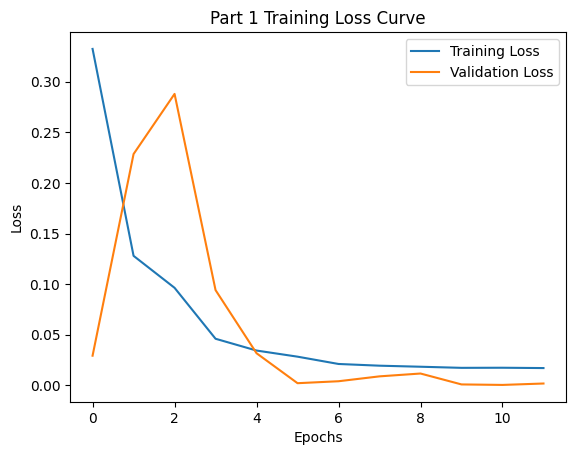

training completed
testing...


100%|██████████| 63/63 [00:02<00:00, 31.39it/s]

Testing accuracy for PART 1 model 84.52%
testing completed
PART 1 -- Completed


In [20]:
training_dir_labels = "data/train.csv"
testing_dir_labels = "data/test.csv"
dir_img = "data/images/"
num_epochs = 12
batch_size = 64
save_model = "models/part1model.pth"
plot_name = "loss_plots/part1model"

transform = transforms.Compose([
    transforms.Resize((80, 60)),
    transforms.ToTensor()
    ]) 

training_dataset = myDataset(dir_imgs=dir_img, dir_labels=training_dir_labels, transforms=transform)
traininglength = int(len(training_dataset) * 0.9)
validationlength = len(training_dataset) - traininglength
trainset, validationset = random_split(training_dataset,[traininglength, validationlength])
testing_dataset = myDataset(dir_imgs=dir_img, dir_labels=testing_dir_labels, transforms=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

print("PART 1 -- Starting")

model = myCNNModel()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

model.train()
model.to(device=device)

train(model=model, trainloader=train_loader, validationloader=validation_loader, epochs=num_epochs, loss_fn=loss_fn, optimizer=optimizer, 
        scheduler=scheduler, device=device, save_model=save_model, plot_name=plot_name, part=1)

model = myCNNModel()
model.load_state_dict(torch.load(save_model))
model.to(device=device)

test(model=model, dataloader=test_loader, device=device, part=1)

print("PART 1 -- Completed")


### PART 1 Results

After training and testing the model, we can see it produces a desirable output. The training results show a loss plot displaying the training and validation losses that were calculated at the end of each epoch. The two curves follow a similar trend with them converging around 0.03 after 12 epochs. The total training time was about 11 minutes long. Testing the model we can see an accuracy of 84.52% was produced. This means the model was able to accurately classify 84.52% of the images that it has not been trained on. Therefore, I believe the baseline model being not perfect did produce a satisfying result.

## PART 2

### PART 2.1

For part 2.1 the hyper-parameter I decided to tune was gamma located on line 30 within the StepLR scheduler. This parameter is used to determine when the learning rate should be applied. In the case of the following code, it means that every 3 epochs, the learning rate will be multiplied by 0.5 where in part 1 and part 2.2 it will be multiplied by 0.1. This higher gamma results in the learning rate decaying slower which is usually good for training on complex datasets. In part 1 we can see the model converges around epoch 10. Therefore, increasing the gamma, the model will converge later which will increase training time but should result in a model with finer tunned weights. Please note, that I will be keeping all other parameters consistent throughout training.

PART 2.1 -- Starting
training...
Starting Epoch 1 at 12:44:42 PM


100%|██████████| 569/569 [00:55<00:00, 10.18it/s]


Epoch 1 accuracy = 76.38%


100%|██████████| 64/64 [00:01<00:00, 33.51it/s]


Validation accuracy for epoch 1 is 80.22%
Epoch 1 took 57.83 seconds -- about 0 minutes
Starting Epoch 2 at 12:45:40 PM


100%|██████████| 569/569 [00:54<00:00, 10.51it/s]


Epoch 2 accuracy = 82.20%


100%|██████████| 64/64 [00:01<00:00, 33.89it/s]


Validation accuracy for epoch 2 is 78.17%
Epoch 2 took 56.04 seconds -- about 0 minutes
Starting Epoch 3 at 12:46:36 PM


100%|██████████| 569/569 [00:54<00:00, 10.51it/s]


Epoch 3 accuracy = 83.16%


100%|██████████| 64/64 [00:01<00:00, 33.63it/s]


Validation accuracy for epoch 3 is 80.82%
Epoch 3 took 56.02 seconds -- about 0 minutes
Starting Epoch 4 at 12:47:32 PM


100%|██████████| 569/569 [00:54<00:00, 10.47it/s]


Epoch 4 accuracy = 84.45%


100%|██████████| 64/64 [00:01<00:00, 33.91it/s]


Validation accuracy for epoch 4 is 82.22%
Epoch 4 took 56.23 seconds -- about 0 minutes
Starting Epoch 5 at 12:48:28 PM


100%|██████████| 569/569 [00:54<00:00, 10.52it/s]


Epoch 5 accuracy = 84.78%


100%|██████████| 64/64 [00:01<00:00, 33.53it/s]


Validation accuracy for epoch 5 is 83.19%
Epoch 5 took 56.00 seconds -- about 0 minutes
Starting Epoch 6 at 12:49:24 PM


100%|██████████| 569/569 [00:54<00:00, 10.48it/s]


Epoch 6 accuracy = 84.85%


100%|██████████| 64/64 [00:01<00:00, 33.75it/s]


Validation accuracy for epoch 6 is 83.41%
Epoch 6 took 56.22 seconds -- about 0 minutes
Starting Epoch 7 at 12:50:20 PM


100%|██████████| 569/569 [00:54<00:00, 10.47it/s]


Epoch 7 accuracy = 85.41%


100%|██████████| 64/64 [00:01<00:00, 33.75it/s]


Validation accuracy for epoch 7 is 83.71%
Epoch 7 took 56.24 seconds -- about 0 minutes
Starting Epoch 8 at 12:51:17 PM


100%|██████████| 569/569 [00:54<00:00, 10.43it/s]


Epoch 8 accuracy = 85.55%


100%|██████████| 64/64 [00:01<00:00, 33.75it/s]


Validation accuracy for epoch 8 is 83.61%
Epoch 8 took 56.47 seconds -- about 0 minutes
Starting Epoch 9 at 12:52:13 PM


100%|██████████| 569/569 [00:53<00:00, 10.54it/s]


Epoch 9 accuracy = 85.52%


100%|██████████| 64/64 [00:01<00:00, 33.60it/s]


Validation accuracy for epoch 9 is 83.58%
Epoch 9 took 55.90 seconds -- about 0 minutes
Starting Epoch 10 at 12:53:09 PM


100%|██████████| 569/569 [00:54<00:00, 10.51it/s]


Epoch 10 accuracy = 85.79%


100%|██████████| 64/64 [00:01<00:00, 33.79it/s]


Validation accuracy for epoch 10 is 83.76%
Epoch 10 took 56.04 seconds -- about 0 minutes
Starting Epoch 11 at 12:54:05 PM


100%|██████████| 569/569 [00:53<00:00, 10.54it/s]


Epoch 11 accuracy = 85.87%


100%|██████████| 64/64 [00:01<00:00, 33.57it/s]


Validation accuracy for epoch 11 is 83.68%
Epoch 11 took 55.88 seconds -- about 0 minutes
Starting Epoch 12 at 12:55:01 PM


100%|██████████| 569/569 [00:53<00:00, 10.54it/s]


Epoch 12 accuracy = 85.90%


100%|██████████| 64/64 [00:01<00:00, 33.67it/s]


Validation accuracy for epoch 12 is 83.76%
Epoch 12 took 55.88 seconds -- about 0 minutes
Model trained and saved to models/part2_1model.pth
Training Time: 674.927521944046 seconds -- about 11 minutes


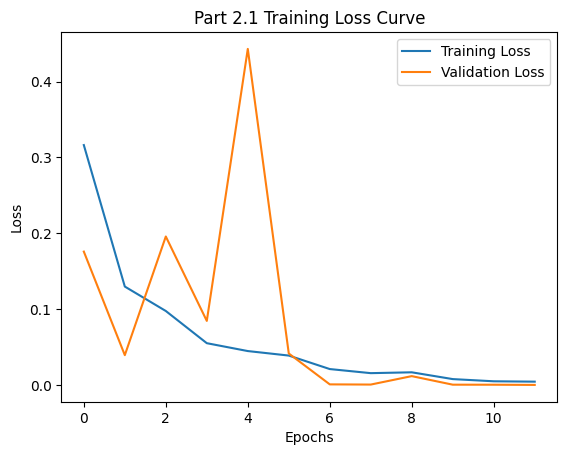

training completed
testing...


100%|██████████| 63/63 [00:01<00:00, 31.73it/s]

Testing accuracy for PART 2.1 model 84.50%
testing completed
PART 2.1 -- Completed


In [21]:
training_dir_labels = "data/train.csv"
testing_dir_labels = "data/test.csv"
dir_img = "data/images/"
num_epochs = 12
batch_size = 64
save_model = "models/part2_1model.pth"
plot_name = "loss_plots/part2_1model"

transform = transforms.Compose([
    transforms.Resize((80, 60)),
    transforms.ToTensor()
    ]) 

training_dataset = myDataset(dir_imgs=dir_img, dir_labels=training_dir_labels, transforms=transform)
traininglength = int(len(training_dataset) * 0.9)
validationlength = len(training_dataset) - traininglength
trainset, validationset = random_split(training_dataset,[traininglength, validationlength])
testing_dataset = myDataset(dir_imgs=dir_img, dir_labels=testing_dir_labels, transforms=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

print("PART 2.1 -- Starting")

model = myCNNModel()

# updated the gamma for part 2.1
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.5)

model.train()
model.to(device=device)

train(model=model, trainloader=train_loader, validationloader=validation_loader, epochs=num_epochs, loss_fn=loss_fn, optimizer=optimizer, 
        scheduler=scheduler, device=device, save_model=save_model, plot_name=plot_name, part=2.1)

model = myCNNModel()
model.load_state_dict(torch.load(save_model))
model.to(device=device)

test(model=model, dataloader=test_loader, device=device, part=2.1)

print("PART 2.1 -- Completed")


### PART 2.1 Results

After adjusting the hyperparameter gamma, then retraining the model and testing it we get results that are interesting. The total training time was about the same as seen in part 1. This was expected as both models were trained for an equal number of epochs and no extra parameters were added to the model (myCNNModel). It is noted that the training and validation losses do trend closer together as it reaches the later epochs. Lastly, the testing results show the model achieved an accuracy of 84.50%. This is very slightly less than the model in part 1 but is negatable in the greater scope. Since the results show such similar scores, it can be stated that changing the gamma does not have a large impact on the overall output of the system for this model/dataset.

### PART 2.2

For part 2.2 the data augmentation is created in the new dataset, myDataset2_2. This dataset is similar to the one used in the previous two examples as it will read the fashion image dataset as normal (read the image and label and give it to the model for training). However, myDataset2 will also augment the data by flipping the images but keeping the same labels. This will result in double the amount of data that the model will be trained on.

PART 2.2 -- Starting
training...
Starting Epoch 1 at 12:56:05 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.26it/s]


Epoch 1 accuracy = 75.44%


100%|██████████| 127/127 [00:02<00:00, 44.22it/s]


Validation accuracy for epoch 1 is 75.52%
Epoch 1 took 103.95 seconds -- about 1 minutes
Starting Epoch 2 at 12:57:49 PM


100%|██████████| 1138/1138 [01:40<00:00, 11.27it/s]


Epoch 2 accuracy = 82.03%


100%|██████████| 127/127 [00:02<00:00, 44.28it/s]


Validation accuracy for epoch 2 is 81.46%
Epoch 2 took 103.84 seconds -- about 1 minutes
Starting Epoch 3 at 12:59:33 PM


100%|██████████| 1138/1138 [01:40<00:00, 11.27it/s]


Epoch 3 accuracy = 83.06%


100%|██████████| 127/127 [00:02<00:00, 44.31it/s]


Validation accuracy for epoch 3 is 82.67%
Epoch 3 took 103.85 seconds -- about 1 minutes
Starting Epoch 4 at 13:01:17 PM


100%|██████████| 1138/1138 [01:40<00:00, 11.27it/s]


Epoch 4 accuracy = 84.60%


100%|██████████| 127/127 [00:02<00:00, 44.16it/s]


Validation accuracy for epoch 4 is 84.81%
Epoch 4 took 103.83 seconds -- about 1 minutes
Starting Epoch 5 at 13:03:01 PM


100%|██████████| 1138/1138 [01:40<00:00, 11.27it/s]


Epoch 5 accuracy = 84.92%


100%|██████████| 127/127 [00:02<00:00, 44.28it/s]


Validation accuracy for epoch 5 is 84.55%
Epoch 5 took 103.81 seconds -- about 1 minutes
Starting Epoch 6 at 13:04:44 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.26it/s]


Epoch 6 accuracy = 85.14%


100%|██████████| 127/127 [00:02<00:00, 44.25it/s]


Validation accuracy for epoch 6 is 84.86%
Epoch 6 took 103.91 seconds -- about 1 minutes
Starting Epoch 7 at 13:06:28 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.23it/s]


Epoch 7 accuracy = 85.36%


100%|██████████| 127/127 [00:02<00:00, 44.30it/s]


Validation accuracy for epoch 7 is 84.93%
Epoch 7 took 104.21 seconds -- about 1 minutes
Starting Epoch 8 at 13:08:12 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.24it/s]


Epoch 8 accuracy = 85.42%


100%|██████████| 127/127 [00:02<00:00, 44.22it/s]


Validation accuracy for epoch 8 is 84.93%
Epoch 8 took 104.13 seconds -- about 1 minutes
Starting Epoch 9 at 13:09:57 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.23it/s]


Epoch 9 accuracy = 85.45%


100%|██████████| 127/127 [00:02<00:00, 44.35it/s]


Validation accuracy for epoch 9 is 84.99%
Epoch 9 took 104.19 seconds -- about 1 minutes
Starting Epoch 10 at 13:11:41 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.23it/s]


Epoch 10 accuracy = 85.49%


100%|██████████| 127/127 [00:02<00:00, 44.30it/s]


Validation accuracy for epoch 10 is 84.95%
Epoch 10 took 104.23 seconds -- about 1 minutes
Starting Epoch 11 at 13:13:25 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.16it/s]


Epoch 11 accuracy = 85.46%


100%|██████████| 127/127 [00:03<00:00, 41.43it/s]


Validation accuracy for epoch 11 is 85.00%
Epoch 11 took 105.03 seconds -- about 1 minutes
Starting Epoch 12 at 13:15:10 PM


100%|██████████| 1138/1138 [01:41<00:00, 11.26it/s]


Epoch 12 accuracy = 85.48%


100%|██████████| 127/127 [00:03<00:00, 41.53it/s]


Validation accuracy for epoch 12 is 84.98%
Epoch 12 took 104.11 seconds -- about 1 minutes
Model trained and saved to models/part2_2model.pth
Training Time: 1249.2739508152008 seconds -- about 20 minutes


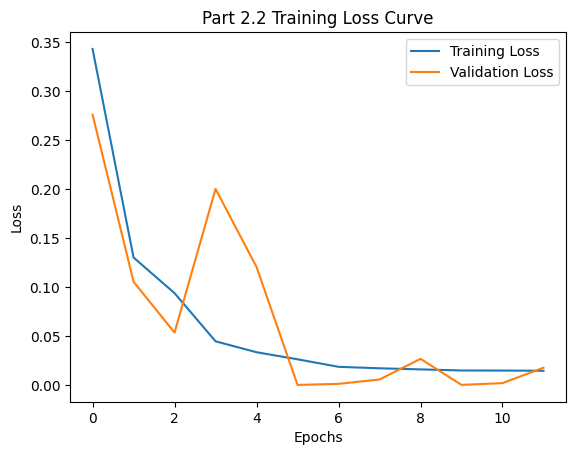

training completed
testing...


100%|██████████| 125/125 [00:03<00:00, 38.87it/s]

Testing accuracy for PART 2.2 model 84.66%
testing completed
PART 2.2 -- Completed


In [22]:
training_dir_labels = "data/train.csv"
testing_dir_labels = "data/test.csv"
dir_img = "data/images/"
num_epochs = 12
batch_size = 64
save_model = "models/part2_2model.pth"
plot_name = "loss_plots/part2_2model"

transform = transforms.Compose([
    transforms.Resize((80, 60)),
    transforms.ToTensor()
    ]) 

# use augmentation dataset for part 2.2
training_dataset = myDataset2_2(dir_imgs=dir_img, dir_labels=training_dir_labels, transforms=transform)
traininglength = int(len(training_dataset) * 0.9)
validationlength = len(training_dataset) - traininglength
trainset, validationset = random_split(training_dataset,[traininglength, validationlength])
testing_dataset = myDataset2_2(dir_imgs=dir_img, dir_labels=testing_dir_labels, transforms=transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

print("PART 2.2 -- Starting")

model = myCNNModel()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

model.train()
model.to(device=device)

train(model=model, trainloader=train_loader, validationloader=validation_loader, epochs=num_epochs, loss_fn=loss_fn, optimizer=optimizer, 
        scheduler=scheduler, device=device, save_model=save_model, plot_name=plot_name, part=2.2)

model = myCNNModel()
model.load_state_dict(torch.load(save_model))
model.to(device=device)

test(model=model, dataloader=test_loader, device=device, part=2.2)

print("PART 2.2 -- Completed")


### PART 2.2 Results

Bringing the model back to the same setup as in part 1, we can see that the model produced better results. It is noted that these results only differ by 0.14%. Looking at the training results, the loss plot shows a desirable curve with the lines trending in a similar trend. The total time to train was about 20 minutes, this was expected as this model was trained on double the amount of data (the original and a copy of the original but flipped vertically). The testing results tells us the accuracy of the model was 84.66%. Due to this very small increase in accuracy with double the training time, I do not believe it would be worth only applying this augmentation to the data. With more data augmentation it is possible the results could be better, however, with more data, the longer the model takes to train and with this trade off, the user must decide if it is worth it.